In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import json
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile

from langdetect import detect
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

sns.set(color_codes=True) # adds a nice background to the graphs

## time
import time

%matplotlib inline

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import random

In [7]:
# !pip install pycaret

In [8]:
"""
:param file - file path

This method takes the file path as input and returns the dataFrame.

"""
def read_csv(file):
    return pd.read_csv(file)

In [9]:
"""
:param df - dataFrame

This method takes the dataFrame as input and print the data info  
    - dataFrame shape, no.of columns, rows
    - column names
    - categorical columns
    - non-categorical columns.

"""
def read_info(df):
    df_shape = df.shape
    df_cols = np.asarray(df.columns)
    df_int_cols = np.asarray(df.select_dtypes('number').columns)
    df_cat_cols = np.asarray(df.select_dtypes('object').columns)
    print(f'shape of dataset: {df_shape} ; number of rows: {df_shape[0]} ; number of columns: {df_shape[1]}')
    print('')
    print(f'cloumns: {df_cols}')
    print('')
    print('feature types::')
    print(df.dtypes)
    print('')
    print(f'non-categorical features: {df_int_cols}')
    print(f'categorical features: {df_cat_cols}')
    print('')

In [10]:
"""
:param df - dataFrame

This method takes the dataFrame and prints the missing/null values in it
"""
def print_missing_values(df):
    # check for null values
    print('null values - info')
    print(df.isnull().sum())
    print('')
    # missing values percentage
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
    print('missing values percentage::')
    print(missing_value_df)
    print('')

In [11]:
"""
:param df - dataFrame

This method takes the dataFrame and handles the missing/null values in it

If the missing values perncentage is greater than the given threshold percentage,
then we it simply drops the rows containig the missing values.
Else it will impute the missing values with `mean`.

"""
def handle_missing_values(df, threshold):
    # check for null values
    print('null values - info')
    null_arr = np.asarray(df.isnull().sum())
    print(df.isnull().sum())
    print('')

    # missing values percentage
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    missing_value_df = pd.DataFrame({'percent_missing': percent_missing}).sort_values(by=['percent_missing'], ascending=False)
    print('missing values percentage (in desc order )::')
    print(missing_value_df)
    print('')
    cols_need_to_drop = []
    for i in df.columns:
        print('column:::', i, ';; percent_missing:: ', percent_missing[i])
        if percent_missing[i] > 0 :
          # If the missing values perncentage is greater than the given threshold percentage, then we simply drops the column containig the missing values.
          if percent_missing[i] > threshold:
            cols_need_to_drop.append(i)
              # print('dropping column::', i)
              # df.drop([i], axis=1, inplace=True)
          else:
              # impute using mean
              mean = df[i].mean()
              df[i].fillna(mean, inplace=True)
    # cols that are need to drop
    print('dropping columns:::', cols_need_to_drop)
    df.drop(cols_need_to_drop, axis=1, inplace=True)
    print('')
    print('null/missing values handled')
    return df

In [12]:
"""
:param df - dataFrame

This method takes the dataFrame and handles the duplicate entries in it

It will drop the identical entries aka duplicates.

"""
def handle_duplicates(df):
    # check for duplicates in the data
    dupes = df.duplicated()
    if sum(dupes) > 0:
        df.drop_duplicates(inplace=True)
    print('duplicates handled')
    print('')
    return df

In [13]:
"""
:param df - dataFrame

This method prints the unique values in each column/entries of dataFrame.

"""
def list_unique_values(df):
    # unique values in each coulmn
    for i in np.asarray(df.columns):
        print(f'unique values in {i} : ')
        print(df[i].unique())
        print('')

In [14]:
"""
:param df - dataFrame

This method prints the values counts in each column/entries of dataFrame.

"""
def value_counts(df):
    # unique values in each coulmn
    for i in np.asarray(df.columns):
        print(f'unique values in {i} : ')
        print(df[i].value_counts())
        print('')

In [15]:
#Performance metrics -MICRO/MACRO/WEIGHTED/SAMPLES
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

average_types = ['micro', 'weighted', 'macro']

"""
:param y_val
:param predicted

This method prints the performace metrices.

"""
def print_performance_scores(y_val, predicted):
  for average_type in average_types:
      print('----------------'+average_type+'--------------------------')
      print('Accuracy score: ', accuracy_score(y_val, predicted))
      print('Recall score: ', recall_score(y_val, predicted, average=average_type))
      print('F1 score: ', f1_score(y_val, predicted, average=average_type))
      print('Precision score: ', precision_score(y_val, predicted, average=average_type))

In [16]:
%pwd

'/content/drive/MyDrive/AI&ML/NLP/project-1'

# **PART A**

## **1. Read and Analyse Dataset**

### **A. Clearly write outcome of data analysis**

In [17]:
%%time

with ZipFile('blogs.zip', 'r') as z:
  z.extractall()

CPU times: user 5.85 s, sys: 1.12 s, total: 6.97 s
Wall time: 12.7 s


In [18]:
blogs_df = read_csv('blogtext.csv')

In [19]:
read_info(blogs_df)

shape of dataset: (681284, 7) ; number of rows: 681284 ; number of columns: 7

cloumns: ['id' 'gender' 'age' 'topic' 'sign' 'date' 'text']

feature types::
id         int64
gender    object
age        int64
topic     object
sign      object
date      object
text      object
dtype: object

non-categorical features: ['id' 'age']
categorical features: ['gender' 'topic' 'sign' 'date' 'text']



In [20]:
blogs_df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [21]:
blogs_df.sample(10)

,id,gender,age,topic,sign,date,text
397230,3547940,female,25,Education,Libra,"06,June,2004",SAVED! was a perfect movie fo...
346483,665500,male,35,indUnk,Aries,"21,January,2003","Lately, I've been... Listening..."
148792,4067860,female,24,indUnk,Capricorn,"29,July,2004","wow, do i ever hate spam!it has never p..."
585159,1636651,female,39,indUnk,Capricorn,"03,July,2003","It was still Bike Night, and me looking..."
68029,3446946,male,23,Education,Virgo,"25,May,2004","Oh sure, start a blog, it's no problem...."
604579,942828,female,34,indUnk,Cancer,"16,October,2003",Fr. Tucker posted a hymn......
622477,4018252,male,23,RealEstate,Pisces,"21,July,2004",Well whoop-de-doo...you can now loo...
115214,3403444,female,14,indUnk,Taurus,"18,June,2004",Bling2xx: watr u doing in thew sumemr ...
90991,3400670,male,16,Student,Scorpio,"05,April,2004",i don't think she did...
557677,3569400,male,33,indUnk,Virgo,"10,June,2004",The last thing that this movie is going...


In [22]:
list_unique_values(blogs_df.iloc[:,:-1])

unique values in id : 
[2059027 3581210 3539003 ... 3561647 4260903 1713845]

unique values in gender : 
['male' 'female']

unique values in age : 
[15 33 14 25 17 23 37 26 24 27 45 34 41 44 16 39 35 36 46 42 13 38 43 40
 47 48]

unique values in topic : 
['Student' 'InvestmentBanking' 'indUnk' 'Non-Profit' 'Banking' 'Education'
 'Engineering' 'Science' 'Communications-Media' 'BusinessServices'
 'Sports-Recreation' 'Arts' 'Internet' 'Museums-Libraries' 'Accounting'
 'Technology' 'Law' 'Consulting' 'Automotive' 'Religion' 'Fashion'
 'Publishing' 'Marketing' 'LawEnforcement-Security' 'HumanResources'
 'Telecommunications' 'Military' 'Government' 'Transportation'
 'Architecture' 'Advertising' 'Agriculture' 'Biotech' 'RealEstate'
 'Manufacturing' 'Construction' 'Chemicals' 'Maritime' 'Tourism'
 'Environment']

unique values in sign : 
['Leo' 'Aquarius' 'Aries' 'Capricorn' 'Gemini' 'Cancer' 'Sagittarius'
 'Scorpio' 'Libra' 'Virgo' 'Taurus' 'Pisces']

unique values in date : 
['14,May,2004' 

In [23]:
value_counts(blogs_df.iloc[:,:-1])

unique values in id : 
449628     4221
734562     2301
589736     2294
1975546    2261
958176     2244
           ... 
3424020       1
4325089       1
3516939       1
3331848       1
3717818       1
Name: id, Length: 19320, dtype: int64

unique values in gender : 
male      345193
female    336091
Name: gender, dtype: int64

unique values in age : 
17    80859
24    80071
23    72889
16    72708
25    67051
26    55312
27    46124
15    41767
14    27400
34    21347
33    17584
35    17462
36    14229
13    13133
37     9317
38     7545
39     5556
40     5016
45     4482
43     4230
41     3738
48     3572
42     2908
46     2733
47     2207
44     2044
Name: age, dtype: int64

unique values in topic : 
indUnk                     251015
Student                    153903
Technology                  42055
Arts                        32449
Education                   29633
Communications-Media        20140
Internet                    16006
Non-Profit                  14700
Engineering   

In [24]:
# print_missing_values(blogs_df)

Distribution of data across gender:


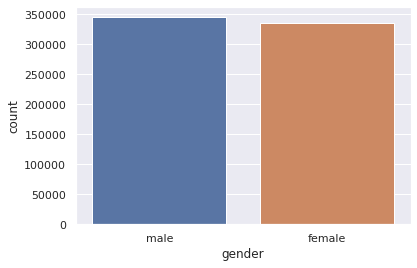

In [25]:
# Lets check the distribution of gender across
print('Distribution of data across gender:')
sns.countplot(blogs_df['gender'])

Distribution of data across sign:


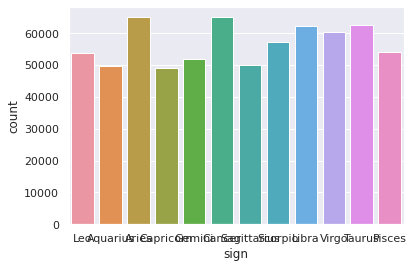

In [26]:
# Lets check the distribution of sign across
print('Distribution of data across sign:')
sns.countplot(blogs_df['sign'])

Distribution of data across age:


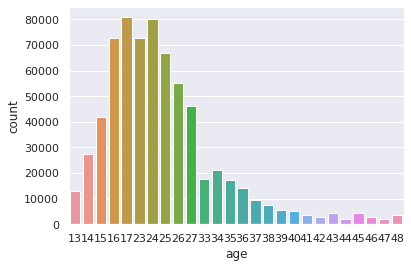

In [27]:
# Lets check the distribution of age across
print('Distribution of data across age:')
sns.countplot(blogs_df['age'])

**Observations :**

* There are almost equal number of bloggers across both the genders.
* The maximum number of bloggers belong to Cancer sign followed by Aries.
* The maximum number of bloggers are of age 17, followed by 24.
* As the age of the bloggers increase, the number of blogs from them decreases as visible in the countplot above.

* As the dataset is huge - we will be restricting it to fewer rows ( 2k )

In [28]:
blogs_df_copy = blogs_df.copy()

In [29]:
# Limiting the data and using fewer rows as the data size is large
blogs_df = blogs_df.sample(2000).reset_index(drop = True)

In [30]:
blogs_df.head()

,id,gender,age,topic,sign,date,text
0,1902492,female,25,indUnk,Pisces,"22,December,2003",It's official. After 3 days of ele...
1,3453622,female,27,indUnk,Virgo,"09,June,2004",urlLink Amanda and Sam celebr...
2,3132358,female,24,indUnk,Aries,"18,May,2004",here's a thing. the us embassy's cultur...
3,3406811,male,27,indUnk,Gemini,"24,June,2004",I thought the Swiss were supposed t...
4,3745488,female,13,Arts,Sagittarius,"24,June,2004",yeh.....i wrote this for julian....... ...


In [31]:
list_unique_values(blogs_df.iloc[:,:-1])

unique values in id : 
[1902492 3453622 3132358 ... 3503919 3359005 2559416]

unique values in gender : 
['female' 'male']

unique values in age : 
[25 27 24 13 37 36 26 16 15 17 33 34 23 35 38 14 40 41 43 44 42 39 45 47
 46 48]

unique values in topic : 
['indUnk' 'Arts' 'Manufacturing' 'RealEstate' 'Law' 'Communications-Media'
 'Technology' 'Biotech' 'Student' 'Internet' 'InvestmentBanking'
 'Education' 'Engineering' 'Telecommunications' 'Banking'
 'Museums-Libraries' 'Tourism' 'BusinessServices' 'Science' 'Military'
 'Non-Profit' 'Advertising' 'Consulting' 'HumanResources' 'Religion'
 'Automotive' 'Agriculture' 'Transportation' 'Sports-Recreation' 'Fashion'
 'Marketing' 'Chemicals' 'Publishing' 'Government' 'Accounting'
 'Construction' 'LawEnforcement-Security' 'Environment' 'Architecture']

unique values in sign : 
['Pisces' 'Virgo' 'Aries' 'Gemini' 'Sagittarius' 'Taurus' 'Capricorn'
 'Aquarius' 'Cancer' 'Scorpio' 'Leo' 'Libra']

unique values in date : 
['22,December,2003' '09,Jun

In [32]:
value_counts(blogs_df.iloc[:,:-1])

unique values in id : 
449628     13
942828      8
734562      8
1975546     8
1270648     8
           ..
3846946     1
3182776     1
2902960     1
1031806     1
2559416     1
Name: id, Length: 1461, dtype: int64

unique values in gender : 
female    1020
male       980
Name: gender, dtype: int64

unique values in age : 
24    259
17    239
16    216
23    211
25    194
26    172
27    133
15    105
14     84
34     61
35     59
33     53
36     42
13     32
37     27
38     20
48     14
39     13
45     13
47     12
40      9
46      8
44      7
42      7
41      6
43      4
Name: age, dtype: int64

unique values in topic : 
indUnk                     760
Student                    451
Technology                 128
Arts                        91
Education                   87
Communications-Media        61
Internet                    46
Engineering                 39
Non-Profit                  38
Science                     27
Law                         26
Consulting              

### **B. Clean the Structured Data**

#### **i. Missing value analysis and imputation**

In [33]:
print_missing_values(blogs_df)

null values - info
id        0
gender    0
age       0
topic     0
sign      0
date      0
text      0
dtype: int64

missing values percentage::
        percent_missing
id                  0.0
gender              0.0
age                 0.0
topic               0.0
sign                0.0
date                0.0
text                0.0



There are no missing values present in the blogs df. Hence, no imputation would be required for missing values

#### **ii. Eliminate Non-English textual data.**

In [34]:
# Eliminating non english textual data using langdetect library

def detect_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

In [35]:
%%time
df = blogs_df[blogs_df['text'].apply(detect_english)]

CPU times: user 13.4 s, sys: 108 ms, total: 13.5 s
Wall time: 13.6 s


In [36]:
read_info(df)

shape of dataset: (1907, 7) ; number of rows: 1907 ; number of columns: 7

cloumns: ['id' 'gender' 'age' 'topic' 'sign' 'date' 'text']

feature types::
id         int64
gender    object
age        int64
topic     object
sign      object
date      object
text      object
dtype: object

non-categorical features: ['id' 'age']
categorical features: ['gender' 'topic' 'sign' 'date' 'text']



## **2. Preprocess unstructured data to make it consumable for model training.**

### **A. Eliminate All special Characters and Numbers**

In [37]:
# Eliminating stop words using NLTK and removing white spaces and converting texts to lower case

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string, re

stop_words = set(stopwords.words('english'))

# Printing all stop words
print('Number of stop words : ', len(stop_words))


Number of stop words :  179


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
%%time 

#Removing Special characters and numbers
df.text = df.text.apply(lambda x: re.sub('[^A-Za-z]+', ' ', x))


CPU times: user 89.7 ms, sys: 1.75 ms, total: 91.5 ms
Wall time: 95.3 ms


In [39]:
df.head(5)

,id,gender,age,topic,sign,date,text
0,1902492,female,25,indUnk,Pisces,"22,December,2003",It s official After days of elevated temps I ...
2,3132358,female,24,indUnk,Aries,"18,May,2004",here s a thing the us embassy s culture offic...
3,3406811,male,27,indUnk,Gemini,"24,June,2004",I thought the Swiss were supposed to always b...
4,3745488,female,13,Arts,Sagittarius,"24,June,2004",yeh i wrote this for julian it means a lot to...
5,4202109,female,25,indUnk,Taurus,"12,August,2004",A rift hangs open in the Eastern sky Touching...


### **B. Lowercase all textual data**

In [40]:
# lowercase conversion
df.text = df.text.apply(lambda x: x.lower())

In [41]:
df.head()

,id,gender,age,topic,sign,date,text
0,1902492,female,25,indUnk,Pisces,"22,December,2003",it s official after days of elevated temps i ...
2,3132358,female,24,indUnk,Aries,"18,May,2004",here s a thing the us embassy s culture offic...
3,3406811,male,27,indUnk,Gemini,"24,June,2004",i thought the swiss were supposed to always b...
4,3745488,female,13,Arts,Sagittarius,"24,June,2004",yeh i wrote this for julian it means a lot to...
5,4202109,female,25,indUnk,Taurus,"12,August,2004",a rift hangs open in the eastern sky touching...


### **C. Remove all Stopwords**

In [42]:
#Removing stopwords
df.text = df.text.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [43]:
df.head()

,id,gender,age,topic,sign,date,text
0,1902492,female,25,indUnk,Pisces,"22,December,2003",official days elevated temps ovulated friday w...
2,3132358,female,24,indUnk,Aries,"18,May,2004",thing us embassy culture office egypt brings s...
3,3406811,male,27,indUnk,Gemini,"24,June,2004",thought swiss supposed always neutral come che...
4,3745488,female,13,Arts,Sagittarius,"24,June,2004",yeh wrote julian means lot duznt make much sen...
5,4202109,female,25,indUnk,Taurus,"12,August,2004",rift hangs open eastern sky touching boundarie...


### **D. Remove all extra white spaces**

In [44]:
# removing spaces
df.text = df.text.apply(lambda x: x.strip())

In [45]:
df.head()

,id,gender,age,topic,sign,date,text
0,1902492,female,25,indUnk,Pisces,"22,December,2003",official days elevated temps ovulated friday w...
2,3132358,female,24,indUnk,Aries,"18,May,2004",thing us embassy culture office egypt brings s...
3,3406811,male,27,indUnk,Gemini,"24,June,2004",thought swiss supposed always neutral come che...
4,3745488,female,13,Arts,Sagittarius,"24,June,2004",yeh wrote julian means lot duznt make much sen...
5,4202109,female,25,indUnk,Taurus,"12,August,2004",rift hangs open eastern sky touching boundarie...


## **3. Build a base Classification model**

### **A. Create dependent and independent variables**

In [46]:
X = df.text
y = df.topic

In [47]:
X.head()

0    official days elevated temps ovulated friday w...
2    thing us embassy culture office egypt brings s...
3    thought swiss supposed always neutral come che...
4    yeh wrote julian means lot duznt make much sen...
5    rift hangs open eastern sky touching boundarie...
Name: text, dtype: object

In [48]:
y = y.astype('category')

### **B. Split data into train and test.**

In [49]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2,test_size = 0.2)

In [50]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1525,)
(1525,)
(382,)
(382,)


### **C. Vectorize data using any one vectorizer.**

In [51]:
def vectorize_data(vectorizer, X_train, X_test):
  X_train_vt = vectorizer.fit_transform(X_train)
  X_test_vt = vectorizer.transform(X_test)
  
  # checking the vocablury size
  print('vocablury size:: ', len(vectorizer.vocabulary_))

  # the feature names
  print('feature names - sample of 20:: ', vectorizer.get_feature_names()[:20])
  print('\n')
  # print X_train_vt
  print('X_train_vt term-document matrix: ')
  print(X_train_vt.toarray())
  print('\n')

  # print X_test_vt
  print('X_test_vt term-document matrix: ')
  print(X_test_vt.toarray())
  print('\n')

  return X_train_vt, X_test_vt

In [52]:
%%time 
count_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))

X_train_bow, X_test_bow = vectorize_data(count_vectorizer, X_train, X_test)

vocablury size::  158829
feature names - sample of 20::  ['aa', 'aa kk', 'aaaa', 'aaaa earth', 'aaaaa', 'aaaaa im', 'aaaaaaa', 'aaaaaaa thats', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaargh brother', 'aaaaaaaaaaahhhhhh', 'aaaaaaaaaaahhhhhh feels', 'aaaaaagggggghhhhhhh', 'aaaaaagggggghhhhhhh fell', 'aaaaarrrggghhh', 'aaaaarrrggghhh badminton', 'aaaargh', 'aaaargh locked', 'aaah', 'aaah heady']


X_train_vt term-document matrix: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


X_test_vt term-document matrix: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


CPU times: user 1.03 s, sys: 647 ms, total: 1.68 s
Wall time: 1.71 s


In [53]:
for topic in df.topic.values:
  print(topic)

indUnk
indUnk
indUnk
Arts
indUnk
Manufacturing
RealEstate
Law
Communications-Media
Communications-Media
Technology
indUnk
Biotech
Student
Internet
Arts
Technology
Student
indUnk
indUnk
Education
indUnk
Student
Student
indUnk
Telecommunications
indUnk
Student
Banking
Student
indUnk
Museums-Libraries
Education
Student
Student
indUnk
Tourism
Student
Student
Technology
Student
Education
Internet
indUnk
Student
indUnk
indUnk
indUnk
Technology
indUnk
indUnk
Technology
Student
indUnk
indUnk
Student
Student
indUnk
indUnk
indUnk
indUnk
Science
Military
Technology
Science
Science
Student
Student
Non-Profit
Technology
Education
indUnk
Student
indUnk
indUnk
Student
Law
Student
Education
Law
indUnk
indUnk
Advertising
Student
indUnk
Consulting
Arts
indUnk
Education
HumanResources
Student
Arts
indUnk
Student
Consulting
Banking
Arts
indUnk
Student
Religion
indUnk
indUnk
indUnk
Automotive
Non-Profit
indUnk
indUnk
Student
indUnk
indUnk
Agriculture
Student
Transportation
Education
Arts
indUnk
indUnk
Educ

In [54]:
%%time 

topic_counts=dict()

for topic in df.topic.values:
  for x in topic:
    if x in topic_counts:
      topic_counts[str(x)]+=1
    else:
      topic_counts[str(x)]=1

CPU times: user 5.81 ms, sys: 0 ns, total: 5.81 ms
Wall time: 5.83 ms


In [55]:
topic_counts

{'i': 1416,
 'n': 2753,
 'd': 1313,
 'U': 724,
 'k': 741,
 'A': 126,
 'r': 349,
 't': 1380,
 's': 349,
 'M': 88,
 'a': 350,
 'u': 725,
 'f': 47,
 'c': 424,
 'g': 313,
 'R': 35,
 'e': 1039,
 'l': 212,
 'E': 130,
 'L': 35,
 'w': 27,
 'C': 88,
 'o': 689,
 'm': 197,
 '-': 110,
 'T': 150,
 'h': 167,
 'y': 131,
 'B': 25,
 'S': 472,
 'I': 45,
 'b': 27,
 'N': 36,
 'P': 55,
 'v': 52,
 'H': 9,
 'p': 15,
 'F': 12,
 'G': 16}

### **D. Build a base model for Supervised Learning - Classification.**

In [56]:
def model_processing(model, X_train, y_train, X_test, y_test):
  
  model = OneVsRestClassifier(model)

  # fit model
  model.fit(X_train,y_train)

  # model predict
  y_pred=model.predict(X_test)

  return model, y_pred

In [57]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
lb = LabelBinarizer()

def model_reports(y_test, y_pred):
  # print classification report
  print('classification report:')
  print(classification_report(y_test, y_pred))
  print('\n')
  print_performance_scores(y_test, y_pred)

  new_y_test = lb.fit_transform(y_test)
  new_y_pred = lb.transform(y_pred)
  print('---------------- ROC-AUC --------------------------')
  print('ROC-AUC score:', roc_auc_score(new_y_test, new_y_pred, average='weighted'))


In [58]:
%%time

# Build a base model for Supervised Learning - Classification
base_model_lg = LogisticRegression(solver='lbfgs')

base_model_lg_ct, y_pred_lg_ct = model_processing(base_model_lg, X_train_bow, y_train, X_test_bow , y_test)

CPU times: user 35 s, sys: 18.2 s, total: 53.2 s
Wall time: 32.8 s


In [59]:
model_reports(y_test, y_pred_lg_ct)

classification report:
                      precision    recall  f1-score   support

          Accounting       0.00      0.00      0.00         1
         Advertising       0.00      0.00      0.00         2
                Arts       0.00      0.00      0.00        14
          Automotive       0.00      0.00      0.00         2
             Banking       0.00      0.00      0.00         3
    BusinessServices       0.00      0.00      0.00         2
           Chemicals       0.00      0.00      0.00         3
Communications-Media       0.00      0.00      0.00        12
          Consulting       0.00      0.00      0.00         6
           Education       0.00      0.00      0.00        14
         Engineering       0.00      0.00      0.00         9
             Fashion       0.00      0.00      0.00         2
          Government       0.00      0.00      0.00         2
      HumanResources       0.00      0.00      0.00         3
            Internet       0.00      0.00     

## **4. Improve Performance of model.**

### **A. Experiment with other vectorisers.**

In [60]:
%%time 
# Try with tf-idf
tf_vectorizer = TfidfVectorizer(binary=True, ngram_range=(1, 2))

X_train_tf, X_test_tf = vectorize_data(tf_vectorizer, X_train, X_test)

vocablury size::  158829
feature names - sample of 20::  ['aa', 'aa kk', 'aaaa', 'aaaa earth', 'aaaaa', 'aaaaa im', 'aaaaaaa', 'aaaaaaa thats', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaargh brother', 'aaaaaaaaaaahhhhhh', 'aaaaaaaaaaahhhhhh feels', 'aaaaaagggggghhhhhhh', 'aaaaaagggggghhhhhhh fell', 'aaaaarrrggghhh', 'aaaaarrrggghhh badminton', 'aaaargh', 'aaaargh locked', 'aaah', 'aaah heady']


X_train_vt term-document matrix: 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


X_test_vt term-document matrix: 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


CPU times: user 1.26 s, sys: 29.7 ms, total: 1.29 s
Wall time: 1.29 s


In [61]:
%%time
base_model_lg_tf, y_pred_lg_tf = model_processing(base_model_lg, X_train_tf, y_train, X_test_tf , y_test)

CPU times: user 26.6 s, sys: 11.7 s, total: 38.3 s
Wall time: 25.9 s


In [62]:
model_reports(y_test, y_pred_lg_tf)

classification report:
                      precision    recall  f1-score   support

          Accounting       0.00      0.00      0.00         1
         Advertising       0.00      0.00      0.00         2
                Arts       0.00      0.00      0.00        14
          Automotive       0.00      0.00      0.00         2
             Banking       0.00      0.00      0.00         3
    BusinessServices       0.00      0.00      0.00         2
           Chemicals       0.00      0.00      0.00         3
Communications-Media       0.00      0.00      0.00        12
          Consulting       0.00      0.00      0.00         6
           Education       0.00      0.00      0.00        14
         Engineering       0.00      0.00      0.00         9
             Fashion       0.00      0.00      0.00         2
          Government       0.00      0.00      0.00         2
      HumanResources       0.00      0.00      0.00         3
            Internet       0.00      0.00     

### **B. Build classifier Models using other algorithms than base model.**

In [63]:
# knn model
base_model_knn = KNeighborsClassifier(n_neighbors= 5 , weights='distance')

In [64]:
%%time
# building knn using Count Vectorizer dataset 
base_model_knn_ct, y_pred_knn_ct = model_processing(base_model_knn, X_train_bow, y_train, X_test_bow , y_test)

CPU times: user 1.36 s, sys: 297 ms, total: 1.66 s
Wall time: 1.69 s


In [65]:
model_reports(y_test, y_pred_knn_ct)

classification report:
                      precision    recall  f1-score   support

          Accounting       0.00      0.00      0.00         1
         Advertising       0.00      0.00      0.00         2
                Arts       0.00      0.00      0.00        14
          Automotive       0.00      0.00      0.00         2
             Banking       0.00      0.00      0.00         3
    BusinessServices       0.00      0.00      0.00         2
           Chemicals       0.00      0.00      0.00         3
Communications-Media       0.00      0.00      0.00        12
          Consulting       0.00      0.00      0.00         6
           Education       0.00      0.00      0.00        14
         Engineering       0.00      0.00      0.00         9
             Fashion       0.00      0.00      0.00         2
          Government       0.00      0.00      0.00         2
      HumanResources       0.00      0.00      0.00         3
            Internet       0.00      0.00     

In [66]:
%%time
# building knn using TF-IDF Vectorizer dataset
base_model_knn_tf, y_pred_knn_tf = model_processing(base_model_knn, X_train_tf, y_train, X_test_tf , y_test)

CPU times: user 1.37 s, sys: 461 ms, total: 1.83 s
Wall time: 1.87 s


In [67]:
model_reports(y_test, y_pred_knn_tf)

classification report:
                      precision    recall  f1-score   support

          Accounting       0.00      0.00      0.00         1
         Advertising       0.00      0.00      0.00         2
                Arts       0.00      0.00      0.00        14
          Automotive       0.00      0.00      0.00         2
             Banking       0.00      0.00      0.00         3
    BusinessServices       0.00      0.00      0.00         2
           Chemicals       0.00      0.00      0.00         3
Communications-Media       0.00      0.00      0.00        12
          Consulting       0.00      0.00      0.00         6
           Education       0.00      0.00      0.00        14
         Engineering       0.00      0.00      0.00         9
             Fashion       0.00      0.00      0.00         2
          Government       0.00      0.00      0.00         2
      HumanResources       0.00      0.00      0.00         3
            Internet       0.00      0.00     

In [68]:
# random classifier
base_model_rf = RandomForestClassifier(max_depth=2,random_state=0)

In [69]:
%%time
# building RandomForestClassifier using Count Vectorizer dataset 
base_model_rf_ct, y_pred_rf_ct = model_processing(base_model_rf, X_train_bow, y_train, X_test_bow , y_test)

CPU times: user 8.31 s, sys: 18.3 s, total: 26.6 s
Wall time: 26.6 s


In [70]:
model_reports(y_test, y_pred_knn_ct)

classification report:
                      precision    recall  f1-score   support

          Accounting       0.00      0.00      0.00         1
         Advertising       0.00      0.00      0.00         2
                Arts       0.00      0.00      0.00        14
          Automotive       0.00      0.00      0.00         2
             Banking       0.00      0.00      0.00         3
    BusinessServices       0.00      0.00      0.00         2
           Chemicals       0.00      0.00      0.00         3
Communications-Media       0.00      0.00      0.00        12
          Consulting       0.00      0.00      0.00         6
           Education       0.00      0.00      0.00        14
         Engineering       0.00      0.00      0.00         9
             Fashion       0.00      0.00      0.00         2
          Government       0.00      0.00      0.00         2
      HumanResources       0.00      0.00      0.00         3
            Internet       0.00      0.00     

In [71]:
%%time
# building knn using TF-IDF Vectorizer dataset
base_model_rf_tf, y_pred_rf_tf = model_processing(base_model_rf, X_train_tf, y_train, X_test_tf , y_test)

CPU times: user 8.43 s, sys: 15.8 s, total: 24.2 s
Wall time: 24.2 s


In [72]:
model_reports(y_test, y_pred_knn_tf)

classification report:
                      precision    recall  f1-score   support

          Accounting       0.00      0.00      0.00         1
         Advertising       0.00      0.00      0.00         2
                Arts       0.00      0.00      0.00        14
          Automotive       0.00      0.00      0.00         2
             Banking       0.00      0.00      0.00         3
    BusinessServices       0.00      0.00      0.00         2
           Chemicals       0.00      0.00      0.00         3
Communications-Media       0.00      0.00      0.00        12
          Consulting       0.00      0.00      0.00         6
           Education       0.00      0.00      0.00        14
         Engineering       0.00      0.00      0.00         9
             Fashion       0.00      0.00      0.00         2
          Government       0.00      0.00      0.00         2
      HumanResources       0.00      0.00      0.00         3
            Internet       0.00      0.00     

* Out of all these models - logistic regression with count vectorizer dataset seems to be performing bit better so will use that model for hypertunign he params ( base_model_lg_ct )

### **C. Tune Parameters/Hyperparameters of the model/s.**

In [73]:
parameters_lr = {
    "estimator__C": [100, 10, 1.0, 0.1, 0.01],
    "estimator__penalty": ['l1', 'l2', 'elasticnet'],
    "estimator__solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}

In [74]:
%%time

random_cv_lg_ct = RandomizedSearchCV(base_model_lg_ct, param_distributions=parameters_lr, n_iter=10, verbose=1)
random_cv_lg_ct.fit(X_train_bow, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 2min 19s, sys: 43 s, total: 3min 2s
Wall time: 2min 34s


RandomizedSearchCV(estimator=OneVsRestClassifier(estimator=LogisticRegression()),
                   param_distributions={'estimator__C': [100, 10, 1.0, 0.1,
                                                         0.01],
                                        'estimator__penalty': ['l1', 'l2',
                                                               'elasticnet'],
                                        'estimator__solver': ['newton-cg',
                                                              'lbfgs',
                                                              'liblinear',
                                                              'sag', 'saga']},
                   verbose=1)

In [75]:
print(random_cv_lg_ct.best_score_)
print(random_cv_lg_ct.best_params_)

0.39081967213114754
{'estimator__solver': 'liblinear', 'estimator__penalty': 'l2', 'estimator__C': 0.01}


In [76]:
y_pred_lg_ct_cv=random_cv_lg_ct.predict(X_test_bow)

### **D. Clearly print Performance Metrics.**

In [77]:
model_reports(y_test, y_pred_lg_ct_cv)

classification report:
                      precision    recall  f1-score   support

          Accounting       0.00      0.00      0.00         1
         Advertising       0.00      0.00      0.00         2
                Arts       0.00      0.00      0.00        14
          Automotive       0.00      0.00      0.00         2
             Banking       0.00      0.00      0.00         3
    BusinessServices       0.00      0.00      0.00         2
           Chemicals       0.00      0.00      0.00         3
Communications-Media       0.00      0.00      0.00        12
          Consulting       0.00      0.00      0.00         6
           Education       0.00      0.00      0.00        14
         Engineering       0.00      0.00      0.00         9
             Fashion       0.00      0.00      0.00         2
          Government       0.00      0.00      0.00         2
      HumanResources       0.00      0.00      0.00         3
            Internet       0.00      0.00     

## **5. Share insights on relative performance comparison**

***A. Which vectorizer performed better? Probable reason?***

*As we saw in the above training for multiple models with different vectorizers( Count Vectorizer and TF-IDF ), Count Vectorizer performed better than TF-IDF*

*Reason for that could be that Count Vectorizers are easy to interpret. It creates vectors with the word count of the document.*

***B. Which model outperformed? Probable reason?***

*Among the different models that are used for training, the Logistic Regession model gave the highest accuracy of all*

*Reason for that could be the simplicity associated with the Logistic Regression Models*

***C. Which parameter/hyperparameter significantly helped to improve performance?Probable reason?***

*All the hyperparameters used in Logistic Regression contributed significantly to improve the performance.*

*However, the C value happens to be the major contributor for improving the performance of the model. The C indicated giving more weightage to the complexity of the model or to the training data that needs to be fit in.*

***D. According to you, which performance metric should be given most importance, why?***

*Out Of all the performance metrices, the performance of the model is best gauged by the ROC-AUC value*. 

*Reason for that could be it indicates the progress of the model by associating a numerical value to it.*